In [64]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

import TLS
import drive

## Transmission spectrum of a periodically modulated TLS

In [40]:
# system parameters
gamma = 1.0
Omega = 20.0*gamma
amp = 5.0*gamma

/Users/zhanyuan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zhanyuan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


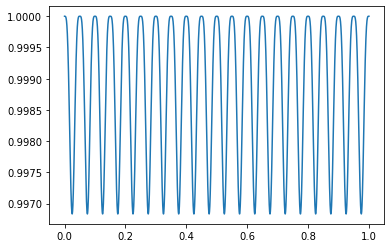

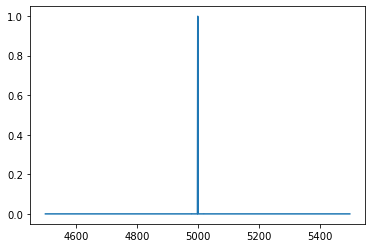

In [41]:
# modulation
def accumulatedPhaseFunc(amp, freq, phase, t):
    """
    The accumulated phase from periodic modulation.
    """
    # return amp*np.sin(freq*2*np.pi*t + phase)
    # return np.exp(-1.0j*(freq*2*np.pi*t + phase))
    return np.exp(1.0j*amp/(freq*2*np.pi)*(np.cos(freq*2*np.pi*t + phase)-1))

numSample = 10000
t = np.linspace(0, 1, numSample)
expDelta_t = accumulatedPhaseFunc(amp, Omega, 0, t)
spectrum = np.fft.fftshift((scipy.fft.fft(expDelta_t))/len(t))
freqRange = np.arange(numSample)
plt.figure()
plt.plot(t, expDelta_t)
plt.figure()
plt.plot(freqRange[4500:5500], spectrum[4500:5500])
#a = 1
#spectrum[400 + 1]

In [42]:
fourierComp = []
for ii in range(31):
    fourierComp.append(spectrum[4700 + 20*ii])
print(len(fourierComp))
fourierComp

31


[(-1.659940783024518e-09-1.766217616086069e-08j),
 (-1.7779735568443897e-09-2.0304486370770915e-08j),
 (-1.913541938711287e-09-2.3584619193236227e-08j),
 (-2.0707011598926565e-09-2.772623369301566e-08j),
 (-2.2547400130614975e-09-3.3060680032585124e-08j),
 (-2.4725696352657665e-09-4.009603405729474e-08j),
 (-2.733090715010243e-09-4.964412125143122e-08j),
 (-3.047066395929724e-09-6.306903985167485e-08j),
 (-3.424497037337322e-09-8.281179980683598e-08j),
 (-3.860739724229133e-09-1.1361062888812257e-07j),
 (-4.263702053044788e-09-1.6570379375658592e-07j),
 (2.4923508694725606e-09-2.6561811141384097e-07j),
 (-7.442957360765787e-08-1.8082655772003985e-06j),
 (-0.00019766982201579024+9.029850358861496e-06j),
 (0.0009160532797783335+0.019870189902190066j),
 (0.9988132178752178-0.03975851970102924j),
 (0.0006662913532615857+0.019880132197574982j),
 (-0.00019783431676898675+4.059537141824181e-06j),
 (-6.2228294386582064e-09-1.8097860192590744e-06j),
 (1.5835003826136966e-08-2.6515739775568093e-

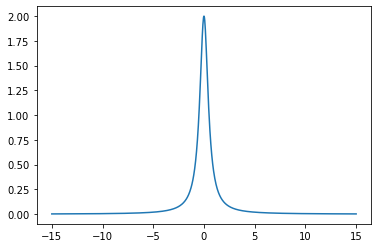

In [43]:
inputFreq = np.linspace(-15.0*gamma, 15.0*gamma, 1000)
transmission = []
for nu in range(1000):
    Snu = 0.0
    for p in range(-30, 30):
        Sp = 0.0 + 0.0j
        for n in range(-15, 15):
            alpha_n = np.conjugate(fourierComp[15 + n])
            alpha_pn = 0.0 + 0.0j
            if ((n + p) <= 15) and ((n + p) >= -15):
                alpha_pn = fourierComp[15 + n + p]
            Spn = -np.sqrt(gamma/2)*alpha_n*alpha_pn/(1.0j*(n*0.25*gamma - inputFreq[nu]) + gamma/2)
            Sp += Spn
        Snu += np.abs(Sp)**2
    transmission.append(Snu)

plt.figure()
plt.plot(inputFreq, transmission)

In [65]:
def compute_single_ph_gfunc_adiabatically(
        sys: TLS.modulatedTLS,
        freqs: np.ndarray,
        num_dt: float) -> np.ndarray:
    """Computes the single-photon scattering matrix in the adiabatic limit.
    This computes the Green's function by simply averaging over the Green's
    function computed with the instantaneous operators over one period.
    Args:
        obj: The floquet analyzer object corresponding to the system under
            consideration.
        freqs: The frequencies at which to compute the Green's function.
        dt: The time-step to use while averaging the transmission through the
            modulated Hamiltonian.
    Returns:
        The single-photon Green's function as a function of the input frequency
        in the adiabatic approximation.
    """
    # We first diagonalize the effective Hamiltonian within the
    # single-excitatoin subspace as a function of time.
    eig_vals = []
    eig_vecs = []
    eig_vecs_inv = []
    for tstep in range(num_dt):
        t = tstep * sys.period / (num_dt - 1)
        Heff = np.array([[0.0 + 0.0j, 0.0 + 0.0j], [0.0 + 0.0j, sys.hamiltonianTot(t)]])
        eig_val, eig_vec = np.linalg.eig(Heff)
        eig_vals.append(eig_val)
        eig_vecs.append(eig_vec)
        eig_vecs_inv.append(np.linalg.inv(eig_vec))

    # Setup the time-independent coupling operator.
    decay_op = np.array([[0.0, 1.0], [0.0, 0.0]])*np.sqrt(sys._gamma)
    ex_op = decay_op.conj().T

    # Calculate the transmission as a function of time.
    trans = []
    for eig_val, eig_vec, eig_vec_inv in zip(
            eig_vals, eig_vecs, eig_vecs_inv):
        # Compute the left and right vectors.
        vec_left = (decay_op @ eig_vec_inv)[0]
        vec_right = (eig_vec @ ex_op)[:, 0]
        # Compute the transmission at all frequencies.
        lor = 1 / (freqs[:, np.newaxis] - eig_val[np.newaxis, :])
        trans_amp = np.sum(vec_left * (lor * vec_right), axis=1)
        trans.append(np.abs(trans_amp)**2)

    return np.mean(trans, axis=0)

In [80]:
gamma = 1.0
delta_max = 5.0 * gamma
inp_freqs = np.linspace(-15 * gamma, 15 * gamma, 1000)

# Fast modulation regime.
freq_fast = 10.0 * gamma
num_harmonics_fast = 500
delta = drive.sinDrive(0, delta_max, 0.0, freq_fast)
tls_obj = TLS.modulatedTLS(0, gamma, delta)

eig_vals = []
eig_vecs = []
eig_vecs_inv = []
for tstep in range(1001):
    t = tstep * tls_obj.period / (1001 - 1)
    Heff = np.array([[0.0 + 0.0j, 0.0 + 0.0j], [0.0 + 0.0j, tls_obj.hamiltonianTot(t)]])
    eig_val, eig_vec = np.linalg.eig(Heff)
    eig_vals.append(eig_val)
    eig_vecs.append(eig_vec)
    eig_vecs_inv.append(np.linalg.inv(eig_vec))

# Setup the time-independent coupling operator.
decay_op = np.array([[0.0, 1.0], [0.0, 0.0]])*np.sqrt(tls_obj._gamma)
ex_op = decay_op.conj().T

# Calculate the transmission as a function of time.
trans = []
for eig_val, eig_vec, eig_vec_inv in zip(
    eig_vals, eig_vecs, eig_vecs_inv):

    # Compute the left and right vectors.
    vec_left = (decay_op @ eig_vec_inv)[0]
    vec_right = (eig_vec @ ex_op)[:, 0]
    # Compute the transmission at all frequencies.
    lor = 1 / (inp_freqs[:, np.newaxis] - eig_val[np.newaxis, :])
    trans_amp = np.sum(vec_left * (lor * vec_right), axis=1)
    trans.append(np.abs(trans_amp)**2)

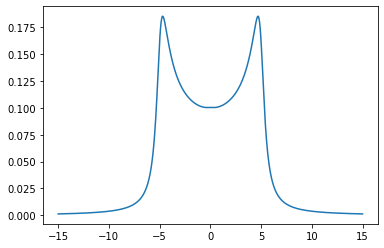

In [81]:
plt.figure()
plt.plot(inp_freqs, 0.25*np.mean(trans, axis=0))

In [ ]:
tls_obj.period